In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from features.dependence import GetXYData
from models.dependence import HSICDependence
from visualization.dependence import plot_raw_variables, plot_sens_mod, plot_sens_angle, plot_sens_scatters
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df
from kernellib.dependence import HSIC, RHSIC

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('ggplot')
import cartopy
import cartopy.crs as ccrs
from tqdm import tqdm
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figure_path = '/home/emmanuel/projects/2019_sakame/reports/figures/dependence/'

### Extract Data

In [3]:
year = '2011'

In [4]:
xr_dataset = xr.merge([
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/*e.nc'),
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity/*.nc')]
)



# Extract summertime months
xr_dataset = xr_dataset.sel(time=slice(str(2008), str(2010))) #.resample(time='1MS').mean(dim='time', skipna=True)

# Extract russian, european region
xr_dataset_r = xr_dataset.sel(lat = slice(66.75, 48.25), lon = slice(28.75, 60.25))
xr_dataset = xr_dataset.sel(lat = slice(70.,30.), lon = slice(-20.,35.))


# extract dates
dates = xr_dataset.time.data


In [6]:
xr_dataset

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 160, lon: 220, time: 138)
Coordinates:
  * lon                         (lon) float32 -19.875 -19.625 ... 34.625 34.875
  * lat                         (lat) float32 69.875 69.625 ... 30.375 30.125
  * time                        (time) datetime64[ns] 2008-01-05 ... 2010-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(138, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(138, 220, 2), chunksize=(46, 220, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(138, 160, 2), chunksize=(46, 160, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 160, 220), chunksize=(46, 160, 220)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 160, 220), chunksize=(46, 160, 220)>

In [7]:
xr_dataset_r

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 74, lon: 126, time: 138)
Coordinates:
  * lon                         (lon) float32 28.875 29.125 ... 59.875 60.125
  * lat                         (lat) float32 66.625 66.375 ... 48.625 48.375
  * time                        (time) datetime64[ns] 2008-01-05 ... 2010-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(138, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(138, 126, 2), chunksize=(46, 126, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(138, 74, 2), chunksize=(46, 74, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 74, 126), chunksize=(46, 74, 126)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 74, 126), chunksize=(46, 74, 126)>

### Plot Raw Variables

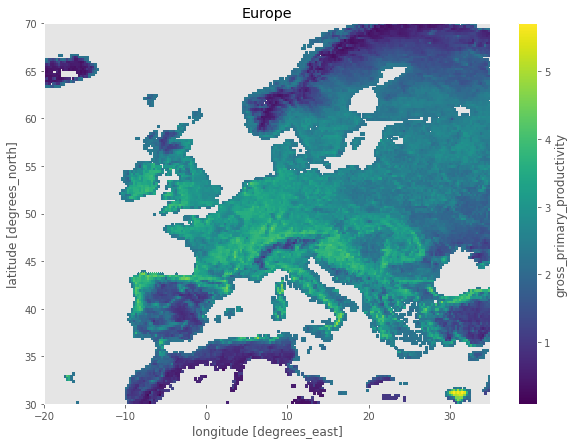

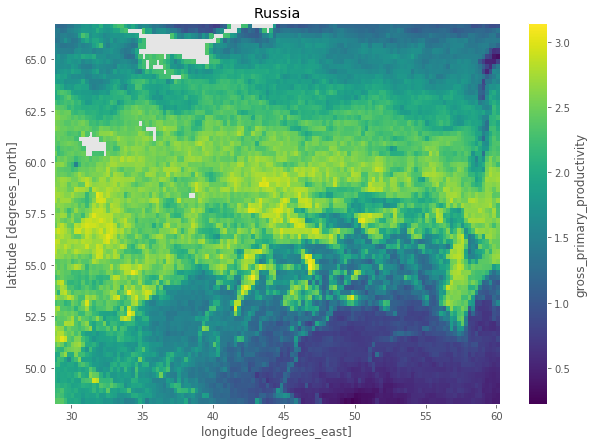

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset['gross_primary_productivity'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Europe')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset_r['gross_primary_productivity'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Russia')
plt.show()

<Figure size 432x288 with 0 Axes>

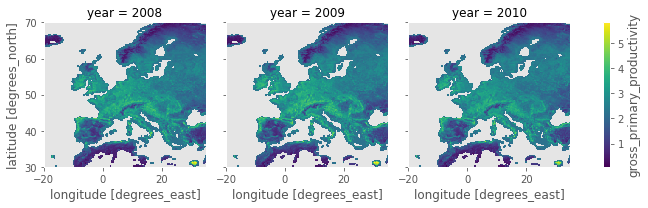

<Figure size 432x288 with 0 Axes>

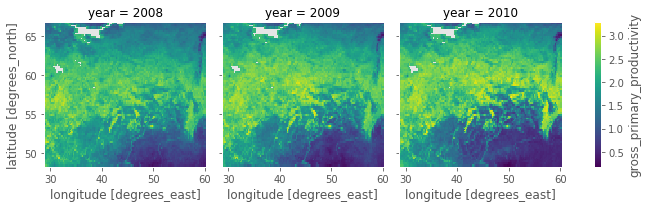

In [9]:
plt.figure()
xr_dataset['gross_primary_productivity'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()


plt.figure()
xr_dataset_r['gross_primary_productivity'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()

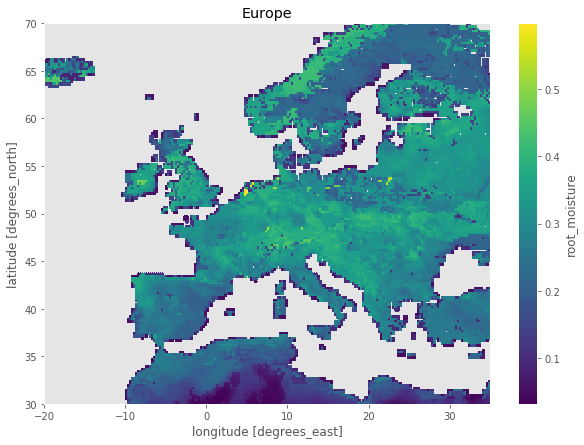

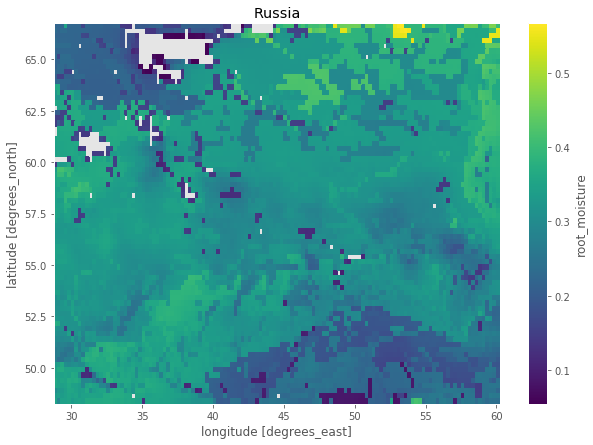

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset['root_moisture'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Europe')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset_r['root_moisture'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Russia')
plt.show()

<Figure size 432x288 with 0 Axes>

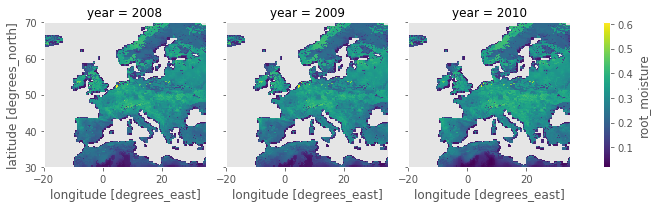

<Figure size 432x288 with 0 Axes>

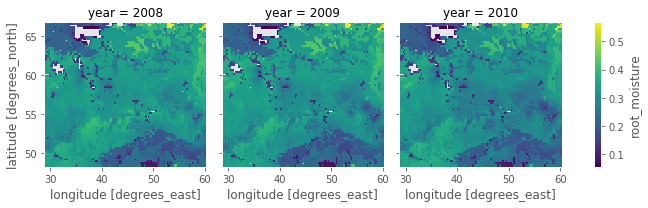

In [11]:
plt.figure()
xr_dataset['root_moisture'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()

plt.figure()
xr_dataset_r['root_moisture'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()

In [7]:
def get_integrals(data):
    
    areas = dict()
    
    # Before Drought
    marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
    areas['year'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # During Droughty
    marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
    areas['before_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
    areas['after_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
    areas['drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    return pd.DataFrame(data=areas, index=['2008', '2009', '2010'])

## Experiment 0 - Pearson Correlation - Time

In [8]:
def pearson_corr_coeff(X, Y):
    
    # Get Mean
    X_mean = X.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    Y_mean = Y.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    
    # Calculate Covariance
    cov = (X - X_mean) * (Y - Y_mean)
    print(cov)
    # Get STD
    X_std = X.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    Y_std = Y.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    
    # Get Correlation Coefficient
    corr_coef = cov / (X_std * Y_std)

    # Get mean of coordinates
    corr_coef = corr_coef.mean(dim=['lat', 'lon'], skipna=True).compute()

    return corr_coef

In [9]:
%%time

phsic_times = pearson_corr_coeff(
    xr_dataset.gross_primary_productivity,
    xr_dataset.root_moisture,
)

phsic_times_r = pearson_corr_coeff(
    xr_dataset_r.gross_primary_productivity,
    xr_dataset_r.root_moisture,
)

<xarray.DataArray (time: 138, lat: 160, lon: 220)>
dask.array<shape=(138, 160, 220), dtype=float32, chunksize=(1, 160, 220)>
Coordinates:
  * lon      (lon) float32 -19.875 -19.625 -19.375 ... 34.375 34.625 34.875
  * lat      (lat) float32 69.875 69.625 69.375 69.125 ... 30.625 30.375 30.125
  * time     (time) datetime64[ns] 2008-01-05 2008-01-13 ... 2010-12-31
<xarray.DataArray (time: 138, lat: 74, lon: 126)>
dask.array<shape=(138, 74, 126), dtype=float32, chunksize=(1, 74, 126)>
Coordinates:
  * lon      (lon) float32 28.875 29.125 29.375 29.625 ... 59.625 59.875 60.125
  * lat      (lat) float32 66.625 66.375 66.125 65.875 ... 48.875 48.625 48.375
  * time     (time) datetime64[ns] 2008-01-05 2008-01-13 ... 2010-12-31
CPU times: user 9.21 s, sys: 13.6 s, total: 22.8 s
Wall time: 3.83 s


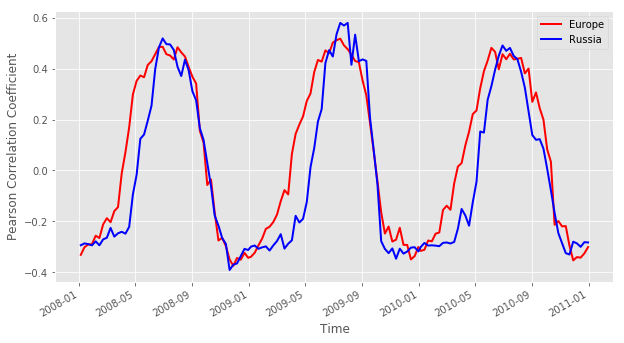

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

phsic_times.plot(ax=ax, label='Europe', color='red', linewidth=2)
phsic_times_r.plot(ax=ax, label='Russia', color='blue', linewidth=2)
ax.set_ylabel('Pearson Correlation Coefficient')
ax.set_xlabel('Time')
ax.legend()
fig.savefig(figure_path + '0_pearson_46.png')
plt.show()

## Experiment I - Linear HSIC - Time

### Europe

In [12]:
# Get Time stamps
times = xr_dataset.time.data

# Initialize variables
lhsic_times = list()
lhsic_mods = list()
pbar = tqdm(times)
try:
    for itime in pbar:
        # Subset region (monthly time cycle)
        subset = xr_dataset.sel(time=slice(itime, itime)) 


        subsample = 5000
        normalize = False
        variables = [
            'gross_primary_productivity',
            'root_moisture',
        ]

        # Initialize Feature-Getter Class
        data_features = GetXYData(
            subsample=subsample,
            normalize=normalize,
            variables=variables,
        )

        X, Y, lat, lon = data_features.set_XY(subset)
    #     fig, ax = plt.subplots()

    #     ax.hist(X, bins=100)
    #     plt.show()
    #     fig, ax = plt.subplots()

    #     ax.hist(Y, bins=100)
    #     plt.show()
        model = 'linear'
        subsample = 5000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
    #     print(X.shape, Y.shape)
        lhsic_model.fit_model(X[:, None] , Y[:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods.append(lhsic_model.get_mod())
        lhsic_times.append(hsic_val)
    #     break
except KeyboardInterrupt:
    pbar.close()

100%|██████████| 138/138 [07:49<00:00,  3.40s/it]


In [13]:
# Save Results
results = dict()

# Linear HSIC (Europe)
results['lhsic_mods'] = lhsic_mods
results['lhsic_times'] = lhsic_times

# Linear HSIC (Russia)
results['lhsic_mods_r'] = lhsic_mods
results['lhsic_times_r'] = lhsic_times

# Linear dHSIC
# results['']

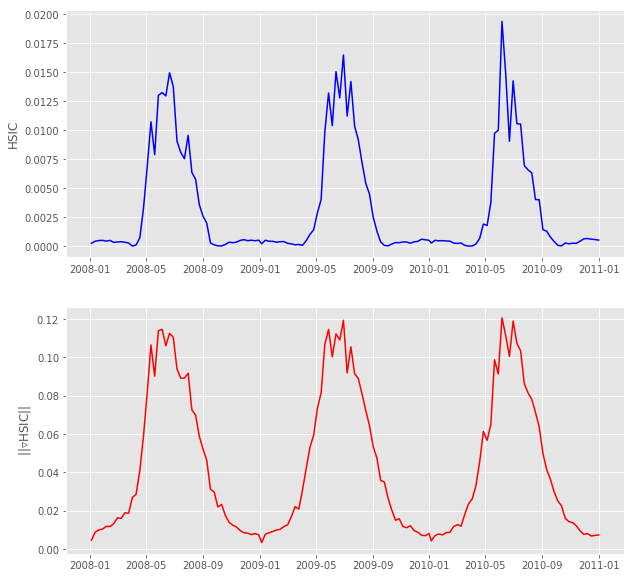

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(times, lhsic_times, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(lhsic_mods).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

### Russia

In [15]:
# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
lhsic_times_r = list()
lhsic_mods_r = list()
pbar = tqdm(times)
try:
    for itime in pbar:
        # Subset region (monthly time cycle)
        subset = xr_dataset_r.sel(time=slice(itime, itime)) 


        subsample = 4000
        normalize = False
        variables = [
            'gross_primary_productivity',
            'root_moisture',
        ]

        # Initialize Feature-Getter Class
        data_features = GetXYData(
            subsample=subsample,
            normalize=normalize,
            variables=variables,
        )

        X, Y, lat, lon = data_features.set_XY(subset)

        model = 'linear'
        subsample = 4000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:, None] , Y[:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods_r.append(lhsic_model.get_mod())
        lhsic_times_r.append(hsic_val)
except KeyboardInterrupt:
    pbar.close()

100%|██████████| 138/138 [04:32<00:00,  2.03s/it]


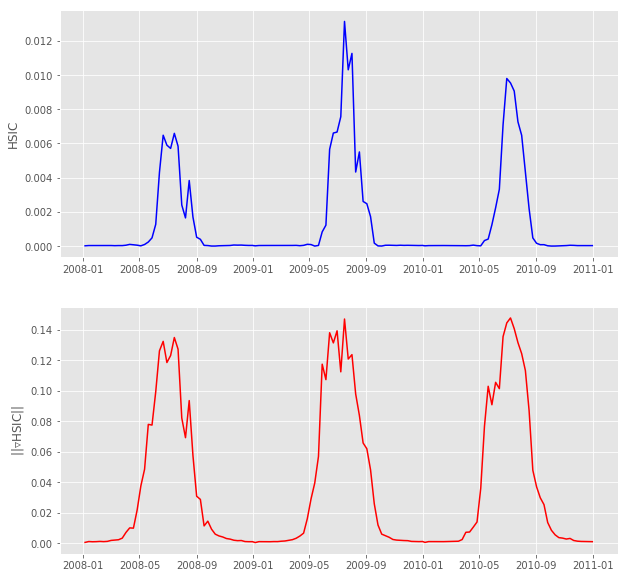

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(times, lhsic_times_r, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(lhsic_mods_r).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

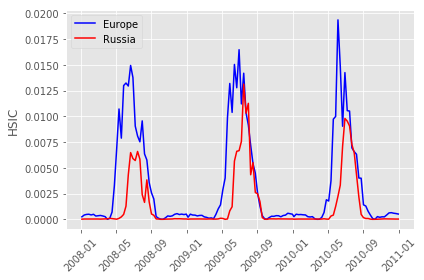

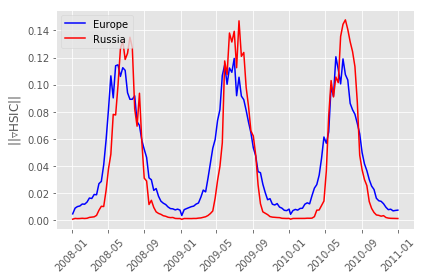

In [18]:
# HSIC
fig, ax = plt.subplots(nrows=1)
ax.plot(times, lhsic_times, label='Europe', color='blue')
ax.plot(times, lhsic_times_r, label='Russia', color='red')
# ax.plot(times, np.array(lhsic_times) - np.array(lhsic_times_r), label='EU-R', color='green')
ax.set_ylabel('HSIC')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# fig.savefig(figure_path + 'lhsic_46.png')
plt.show()

# dHSIC
fig, ax = plt.subplots()
ax.plot(times, np.hstack(lhsic_mods).mean(axis=0), label='Europe', color='blue')
ax.plot(times, np.hstack(lhsic_mods_r).mean(axis=0), label='Russia', color='red')
ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'ldhsic_46.png')
plt.show()

# # P-Value HSIC (Europe, Russia)
# fig, ax = plt.subplots()
# ax.plot(times, np.abs(np.array(lhsic_times_r) - np.array(lhsic_times)), color='green')
# ax.set_ylabel(r'$\Delta_p$')
# plt.xticks(rotation=45)
# plt.tight_layout()
# fig.savefig(figure_path + 'lphsic_46.png')
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(times, np.abs(np.hstack(lhsic_mods).mean(axis=0) - np.hstack(lhsic_mods_r).mean(axis=0)), color='green')
# ax.set_ylabel(r'$\Delta_p$||$\triangledown$HSIC||')
# plt.xticks(rotation=45)
# plt.tight_layout()
# fig.savefig(figure_path + 'lpdhsic_46.png')
# plt.show()

# for iax in [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]:
#     for label in iax.get_xticklabels():
#         label.set_rotation(45) 


# fig.savefig(figure_path + 'lhsic_46.png')


# plt.show()

In [19]:
marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]

In [20]:
for x, y  in marks:

    t1 = np.concatenate([ldhsic_delta[x[0]:x[1]] , ldhsic_delta[y[0]:y[1]]])
    break

NameError: name 'ldhsic_delta' is not defined

In [21]:
marks = [((0, 18), (31, 46)), ((46, 46 + 18), (46 + 31, 46*2)), ((2*46, 2*46 + 18), (2*46 + 31, 46*3))]

areas['non_drought'] = [np.trapz(np.concatenate([ldhsic_delta[x[0]:x[1]] , 
                                             ldhsic_delta[y[0]:y[1]]])) for x, y  in marks]

NameError: name 'ldhsic_delta' is not defined

In [22]:
marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
areas['before_drought'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

NameError: name 'ldhsic_delta' is not defined

In [ ]:
marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
areas['after_drought'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

In [32]:
np.array(lhsic_times).shape

(138,)

In [34]:
def get_integrals(data):
    
    areas = dict()
    
    # Before Drought
    marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
    areas['year'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # During Droughty
    marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
    areas['before_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
    areas['after_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
    areas['drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    return pd.DataFrame(data=areas, index=['2008', '2009', '2010'])


In [36]:
lhsic_delta = np.abs(np.array(lhsic_times) - np.array(lhsic_times_r))
ldhsic_delta = np.abs(np.hstack(lhsic_mods).mean(axis=0) - np.hstack(lhsic_mods_r).mean(axis=0))

df = get_integrals(lhsic_delta)
ddf = get_integrals(ldhsic_delta)

In [37]:
df, ddf

(          year  before_drought  after_drought   drought
 2008  0.112159        0.032894       0.005602  0.073662
 2009  0.085257        0.022326       0.004366  0.058566
 2010  0.081857        0.020256       0.006381  0.055219,
           year  before_drought  after_drought   drought
 2008  0.776259        0.342229       0.162319  0.271711
 2009  0.807972        0.408386       0.156193  0.243394
 2010  0.755190        0.270600       0.153258  0.331332)

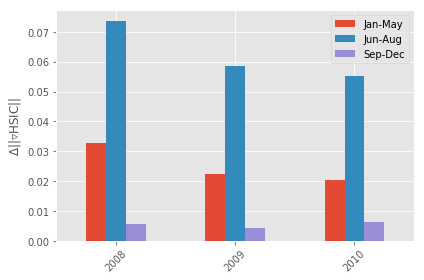

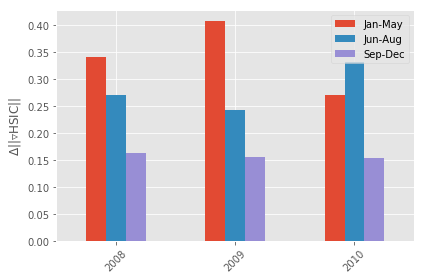

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# Plot Europe
df[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax, stacked=False)
ax.set_ylabel(r'$\Delta$||$\triangledown$HSIC||')
ax.legend(['Jan-May', 'Jun-Aug', 'Sep-Dec'])
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'lhsic_bar_46.png', transparent=False)
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1)

# Plot Europe
ddf[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax, stacked=False)
ax.set_ylabel(r'$\Delta$||$\triangledown$HSIC||')
ax.legend(['Jan-May', 'Jun-Aug', 'Sep-Dec'])
plt.xticks(rotation=45)
plt.tight_layout()
# fig.savefig(figure_path + 'ldhsic_bar_46.png', transparent=False)
plt.show()